In [ ]:
from pathlib import Path
import json, rasterio
DATA_ROOT = Path("0k_251k_uint8_jpeg_tif/s2c")

# Detect whether the 's2c' layer exists
if (DATA_ROOT / "s2c").is_dir():
    DATA_ROOT = DATA_ROOT / "s2c"

# Peek at the first patch
patch_id = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])[0]
print("First patch:", patch_id.name)

seasons = sorted([s for s in patch_id.iterdir() if s.is_dir()])
print("Seasons:", [s.name for s in seasons])

bands = sorted(seasons[0].glob("*.tif"))
print("Bands  :", [b.stem for b in bands])

with rasterio.open(bands[1]) as src:
    print("Shape  :", src.shape, "dtype:", src.dtypes[0])


First patch: 0000000
Seasons: ['20200328T162829_20200328T164812_T15QXA', '20200621T162901_20200621T164746_T15QXA', '20200924T162929_20200924T164434_T15QXA', '20201228T163711_20201228T164519_T15QXA']
Bands  : ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
Shape  : (44, 44) dtype: uint8


In [ ]:
from collections import Counter
import random, rasterio, numpy as np

# 1) Count patches and make sure all have 4 seasons × 13 bands
patch_dirs = [p for p in DATA_ROOT.iterdir() if p.is_dir()]
summary = Counter()

for p in random.sample(patch_dirs, k=200):        # spot-check 200 patches
    seasons = [s for s in p.iterdir() if s.is_dir()]
    summary[len(seasons)] += 1
    for s in seasons:
        summary[f"{p.name}-{s.name}-bands"] += len(list(s.glob("*.tif")))

print(summary)

# 2) Quick value stats to confirm range is indeed 0–255
sample_band = random.choice(list(patch_dirs[0].rglob("*.tif")))
with rasterio.open(sample_band) as src:
    arr = src.read(1)
print(sample_band, arr.min(), arr.max())


Counter({4: 200, '0153081-20210105T073311_20210105T073312_T39STS-bands': 13, '0153081-20201012T072839_20201012T073934_T39STS-bands': 13, '0153081-20210415T072611_20210415T073141_T39STS-bands': 13, '0153081-20200714T072619_20200714T073608_T39STS-bands': 13, '0026879-20200914T044659_20200914T044701_T46TBM-bands': 13, '0026879-20201218T045211_20201218T045213_T46TBM-bands': 13, '0026879-20210321T045701_20210321T050108_T45TYH-bands': 13, '0026879-20200616T044659_20200616T045625_T46TBM-bands': 13, '0151803-20201210T080329_20201210T082245_T35KMR-bands': 13, '0151803-20200926T075701_20200926T082400_T35KMR-bands': 13, '0151803-20200703T075609_20200703T082231_T35KMR-bands': 13, '0151803-20210330T075609_20210330T082144_T35KMR-bands': 13, '0045361-20201124T033051_20201124T034122_T48PTC-bands': 13, '0045361-20200826T032541_20200826T032643_T48PTC-bands': 13, '0045361-20210309T032549_20210309T034215_T48PTC-bands': 13, '0045361-20210523T032541_20210523T033608_T48PTC-bands': 13, '0061053-20210422T07161

In [ ]:
import torch, rasterio, random
from pathlib import Path
from torchvision.transforms import functional as F


class SSL4EOS2C(torch.utils.data.Dataset):
    def __init__(self, root, size=224, stack_seasons=True,
                 mean=(0.5,), std=(0.5,), augment=True):
        self.root = Path(root)
        if (self.root / "s2c").is_dir():
            self.root = self.root / "s2c"
        self.patch_dirs = sorted([p for p in self.root.iterdir() if p.is_dir()])
        self.size = size
        self.stack = stack_seasons
        self.mean, self.std = mean, std
        self.augment = augment

    def __len__(self):
        return len(self.patch_dirs)

    def _read_tif(self, p):
        with rasterio.open(p) as src:
            arr = torch.from_numpy(src.read(1))  # H×W uint8
        return arr

    def _load_cube(self, patch):
        seasons = sorted([s for s in patch.iterdir() if s.is_dir()])
        band_stacks = []
        for season in seasons:
            bands = [self._read_tif(b) for b in sorted(season.glob("*.tif"))]

            # --- resample all 13 bands to common size -------------------
            target_h, target_w = min(b.shape[0] for b in bands), \
                                 min(b.shape[1] for b in bands)
            bands_rs = []
            for b in bands:
                if b.shape != (target_h, target_w):
                    b = F.interpolate(
                        b.unsqueeze(0).unsqueeze(0).float(),   # 1×1×H×W
                        size=(target_h, target_w),
                        mode="bilinear",
                        align_corners=False
                    ).squeeze(0).squeeze(0).byte()
                bands_rs.append(b)
            band_stacks.append(torch.stack(bands_rs))  # (13, H, W)

        cube = torch.stack(band_stacks)                # (4,13,H,W)
        return cube.view(-1, *cube.shape[-2:]).float() / 255.0  # (52,H,W)


    def _augment(self, x):
        # Bilinear upsample to ViT crop size
        x = torch.nn.functional.interpolate(x.unsqueeze(0),
                                            size=self.size,
                                            mode="bilinear",
                                            align_corners=False).squeeze(0)
        if self.augment:
            # DINO global crop + colour jitter as an example
            i, j, h, w = F.RandomResizedCrop.get_params(
                x, scale=(0.5, 1.0), ratio=(0.75, 1.33))
            x = F.resized_crop(x, i, j, h, w, (self.size, self.size))
            if random.random() < 0.8:
                x = x + 0.2 * torch.randn_like(x)   # crude colour jitter
                x = x.clamp(0, 1)
        x = (x - torch.tensor(self.mean)[:, None, None]) / torch.tensor(self.std)[:, None, None]
        return x

    def __getitem__(self, idx):
        cube = self._load_cube(self.patch_dirs[idx])
        # Two views for DINO (student / teacher)
        view1 = self._augment(cube)
        view2 = self._augment(cube)
        return {"view1": view1, "view2": view2}


In [ ]:
import timm, torch.nn as nn

model = timm.create_model(
    'vit_small_patch14_dinov2',
    pretrained=True,
    num_classes=0                 # drop classifier head for DINO pre-text
)

# --- widen the first conv to 52 channels -------------------------------
old_proj = model.patch_embed.proj     # Conv2d(3, embed_dim, 14, 14)
model.patch_embed.proj = nn.Conv2d(
    in_channels=52,
    out_channels=old_proj.out_channels,
    kernel_size=old_proj.kernel_size,
    stride=old_proj.stride,
    padding=old_proj.padding,
    bias=(old_proj.bias is not None)
)

with torch.no_grad():
    # copy pre-trained RGB kernels
    model.patch_embed.proj.weight[:, :3].copy_(old_proj.weight)
    # average-RGB kernel for extra bands
    filler = old_proj.weight.mean(1, keepdim=True)
    for c in range(3, 52):
        model.patch_embed.proj.weight[:, c:c+1].copy_(filler)



In [ ]:
# ---------- dataset.py ----------
from pathlib import Path
import torch, random, rasterio
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

class SSL4EOS2C(Dataset):
    def __init__(self, root, out_size=224, stack_seasons=True,
                 mean=None, std=None, jitter=True):
        root = Path(root)
        if (root / "s2c").is_dir():
            root = root / "s2c"
        self.patch_dirs = sorted([p for p in root.iterdir() if p.is_dir()])
        self.out_size = out_size
        self.stack   = stack_seasons
        self.jitter  = jitter
        # fallback stats – refine later with a small scan
        self.mean = (0.5,) * (52 if stack_seasons else 13)
        self.std  = (0.5,) * len(self.mean) if std is None else std
        if mean is not None: self.mean = mean

    def __len__(self): return len(self.patch_dirs)

    # ---- helpers -------------------------------------------------------
    @staticmethod
    def _read_band(p):
        with rasterio.open(p) as src:
            return torch.from_numpy(src.read(1))   # (44,44) uint8

    def _load_cube(self, patch):
        seasons = sorted([s for s in patch.iterdir() if s.is_dir()])
        cube = [torch.stack([self._read_band(b) for b in sorted(s.glob("*.tif"))])
                for s in seasons]                 # list of (13,44,44)
        cube = torch.stack(cube)                  # (4,13,44,44)
        return cube.view(-1, 44, 44) / 255.0 if self.stack else cube / 255.0

    def _upsample(self, x):
        return torch.nn.functional.interpolate(
            x.unsqueeze(0), size=self.out_size, mode="bilinear",
            align_corners=False).squeeze(0)

    def _color_jitter(self, x):
        if not self.jitter: return x
        if random.random() < 0.8:
            x = x + 0.2 * torch.randn_like(x)
        return x.clamp(0, 1)

    def _crop(self, x):
        i,j,h,w = F.RandomResizedCrop.get_params(
            x, scale=(0.5,1.0), ratio=(0.75,1.33))
        return F.resized_crop(x, i, j, h, w, (self.out_size, self.out_size))

    def _norm(self, x):
        m = torch.tensor(self.mean, device=x.device)[:,None,None]
        s = torch.tensor(self.std,  device=x.device)[:,None,None]
        return (x-m)/s

    # -------------------------------------------------------------------
    def __getitem__(self, idx):
        cube = self._upsample(self._load_cube(self.patch_dirs[idx]))
        # two augmented views for DINO
        v1 = self._norm(self._color_jitter(self._crop(cube)))
        v2 = self._norm(self._color_jitter(self._crop(cube)))
        return {"view1": v1, "view2": v2}


In [ ]:
# ---------- backbone.py ----------
import timm, torch.nn as nn, torch

def build_dinov2_backbone(in_ch=52):
    model = timm.create_model(
        'vit_small_patch14_dinov2', pretrained=True, num_classes=0)
    old_proj = model.patch_embed.proj            # (3 → embed_dim)

    model.patch_embed.proj = nn.Conv2d(
        in_channels=in_ch,
        out_channels=old_proj.out_channels,
        kernel_size=old_proj.kernel_size,
        stride=old_proj.stride,
        padding=old_proj.padding,
        bias=(old_proj.bias is not None))

    with torch.no_grad():
        # copy RGB kernels; average-RGB filler for extras
        model.patch_embed.proj.weight[:, :3].copy_(old_proj.weight)
        filler = old_proj.weight.mean(1, keepdim=True)
        for c in range(3, in_ch):
            model.patch_embed.proj.weight[:, c:c+1].copy_(filler)
    return model


In [ ]:
import torch, rasterio, random, math, timm, torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from dinov2.loss import DINOLoss
from dinov2.layers import DINOHead
from tqdm import tqdm
from torchvision.transforms import RandomResizedCrop


# ---------- 1. Dataset: always returns (52,44,44) float ------------------
class SSL4EOCube(Dataset):
    def __init__(self, root, size=224):
        root = Path(root)
        if (root / "s2c").is_dir():
            root = root / "s2c"
        self.patch_dirs = sorted([p for p in root.iterdir() if p.is_dir()])
        self.size = size

    def __len__(self):
        return len(self.patch_dirs)

    def _read(self, path):
        with rasterio.open(path) as src:
            return torch.from_numpy(src.read(1))          # H×W uint8

    def _cube_52ch(self, patch):
        seasons = sorted([s for s in patch.iterdir() if s.is_dir()])
        stacks  = []
        for season in seasons:
            bands = [self._read(b) for b in sorted(season.glob("*.tif"))]
            # resample every band to common 44×44 grid
            H = min(b.shape[0] for b in bands)
            W = min(b.shape[1] for b in bands)
            rs = []
            for b in bands:
                if b.shape != (H, W):
                    b = F.resize(b.unsqueeze(0), [H, W],
                                  interpolation=F.InterpolationMode.BILINEAR
                                 ).squeeze(0)
                rs.append(b)
            stacks.append(torch.stack(rs))                 # (13,H,W)
        cube = torch.stack(stacks)                         # (4,13,H,W)
        return cube.view(-1, H, W).float() / 255.0         # (52,H,W)

    def __getitem__(self, idx):
        x = self._cube_52ch(self.patch_dirs[idx])
        # upsample to ViT crop size & random crop once for each view
        x = F.resize(x, [self.size, self.size],
                     interpolation=F.InterpolationMode.BILINEAR)
        i,j,h,w = RandomResizedCrop.get_params(x, (0.5,1.), (0.75,1.33))
        v1 = F.resized_crop(x, i,j,h,w, (self.size,self.size))
        i,j,h,w = RandomResizedCrop.get_params(x,(0.5,1.),(0.75,1.33))
        v2 = F.resized_crop(x, i,j,h,w, (self.size,self.size))
        return {"view1": v1, "view2": v2}

# ---------- 2. Backbone: ViT-S/14 widened to 52 channels -----------------
def build_backbone():
    model = timm.create_model(
        "vit_small_patch14_dinov2",
        pretrained=True,
        num_classes=0,
        img_size=224
    )
    old = model.patch_embed.proj

    new = nn.Conv2d(52, old.out_channels,
                    kernel_size=old.kernel_size,
                    stride=old.stride, padding=old.padding,
                    bias=False)
    with torch.no_grad():
        new.weight[:, :3].copy_(old.weight)
        avg = old.weight.mean(1, keepdim=True)
        for c in range(3,52):
            new.weight[:, c:c+1].copy_(avg)
    model.patch_embed.proj = new
    return model


# ---------- 3. Build everything -----------------------------------------
ROOT   = "0k_251k_uint8_jpeg_tif/s2c"
DEVICE = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available() else "cpu")

ds      = SSL4EOCube(ROOT, size=224)
loader  = DataLoader(ds, batch_size=8, shuffle=True,
                     num_workers=0, pin_memory=False)

print("✓ loader OK  — first batch shape",
      next(iter(loader))["view1"].shape)

student = build_backbone().to(DEVICE)
teacher = build_backbone().to(DEVICE)
for p in teacher.parameters(): p.requires_grad_(False)

head_s = DINOHead(384, 65536).to(DEVICE)
head_t = DINOHead(384, 65536).to(DEVICE)
for p in head_t.parameters(): p.requires_grad_(False)

loss_fn = DINOLoss(out_dim=65536).to(DEVICE)
opt     = torch.optim.AdamW(student.parameters(), lr=1e-4)

# ---------- 4. One quick epoch to prove it works ------------------------
for epoch in range(1):
    for batch in tqdm(loader, desc="epoch 0"):
        v1, v2 = batch["view1"].to(DEVICE), batch["view2"].to(DEVICE)
        s_out  = head_s(student(torch.cat([v1,v2])))
        with torch.no_grad():
            t_out = head_t(teacher(torch.cat([v1,v2])))
        loss = loss_fn(s_out, t_out)
        opt.zero_grad(); loss.backward(); opt.step()
    print("epoch 0  loss =", loss.item())
# ================================================================


✓ loader OK  — first batch shape torch.Size([8, 52, 224, 224])


epoch 0: 100%|██████████| 31385/31385 [24:22:21<00:00,  2.80s/it]      

epoch 0  loss = -49722.765625


In [ ]:
def load_backbone(ckpt_path, device="cpu"):
    model = build_backbone().to(device)
    state  = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["student"], strict=False)
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
    return model


In [ ]:
from torchvision.datasets import EuroSAT
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

mean = [0.485, 0.456, 0.406]          # ImageNet stats just for RGB bands
std  = [0.229, 0.224, 0.225]

eurosat = EuroSAT(
    root="~/data",
    download=True,
    transform=Compose([
        Resize(224),
        ToTensor(),
        Normalize(mean, std),
    ])
)
test_loader = DataLoader(eurosat, batch_size=64, shuffle=False,
                         num_workers=0)


100%|██████████| 94.3M/94.3M [00:08<00:00, 10.6MB/s]


In [ ]:
import torch.nn as nn, torch.optim as optim

device   = "cuda" if torch.cuda.is_available() else "cpu"
backbone = load_backbone("ckpt_epoch000.pt", device)

num_classes = len(eurosat.classes)
probe = nn.Linear(backbone.num_features, num_classes).to(device)

opt  = optim.AdamW(probe.parameters(), lr=1e-3, weight_decay=0)
ce   = nn.CrossEntropyLoss()

# --- extract embeddings once -------------------------------------------
feats, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)                     # (B,3,H,W)
        # --- pad to 52 channels ---------------
        B, _, H, W = x.shape
        pad = torch.zeros(B, 52-3, H, W, device=x.device)
        x52 = torch.cat([x, pad], dim=1)     # (B,52,H,W)
        # --------------------------------------
        f = backbone(x52)                    # (B,384)
        feats.append(f.cpu())
        labels.append(y)
feats  = torch.cat(feats)
labels = torch.cat(labels)


# --- fit linear probe ---------------------------------------------------
dataset = torch.utils.data.TensorDataset(feats, labels)
loader  = DataLoader(dataset, batch_size=256, shuffle=True)

for epoch in range(10):
    running = 0
    for f, y in loader:
        f, y = f.to(device), y.to(device)
        logits = probe(f)
        loss   = ce(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item() * f.size(0)
    print(f"epoch {epoch}  probe-loss {running/len(dataset):.4f}")


epoch 0  probe-loss 2.2927
epoch 1  probe-loss 2.1962
epoch 2  probe-loss 2.1445
epoch 3  probe-loss 2.0901
epoch 4  probe-loss 2.0592
epoch 5  probe-loss 2.0188
epoch 6  probe-loss 1.9936
epoch 7  probe-loss 1.9679
epoch 8  probe-loss 1.9455
epoch 9  probe-loss 1.9251


Note: you may need to restart the kernel to use updated packages.


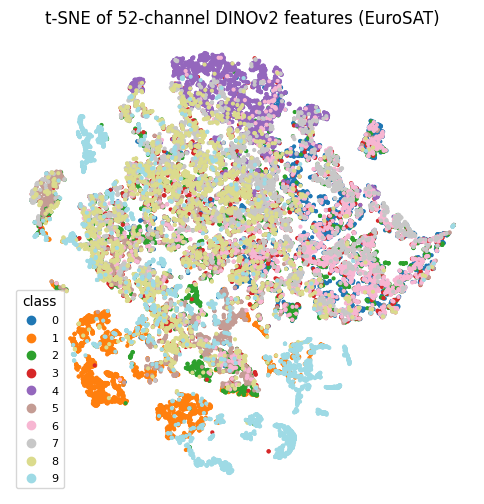

In [ ]:
%pip install scikit-learn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto")
emb2d = tsne.fit_transform(feats.numpy())

plt.figure(figsize=(6,6))
scatter = plt.scatter(emb2d[:,0], emb2d[:,1], c=labels, s=4, cmap="tab20")
plt.legend(*scatter.legend_elements(), loc="best", title="class", fontsize=8)
plt.title("t-SNE of 52-channel DINOv2 features (EuroSAT)")
plt.axis("off")
plt.show()


In [ ]:
for idx, name in enumerate(eurosat.classes):
    print(idx, name)


0 AnnualCrop
1 Forest
2 HerbaceousVegetation
3 Highway
4 Industrial
5 Pasture
6 PermanentCrop
7 Residential
8 River
9 SeaLake


Note: you may need to restart the kernel to use updated packages.
Linear-probe Top-1 accuracy: 36.16 %


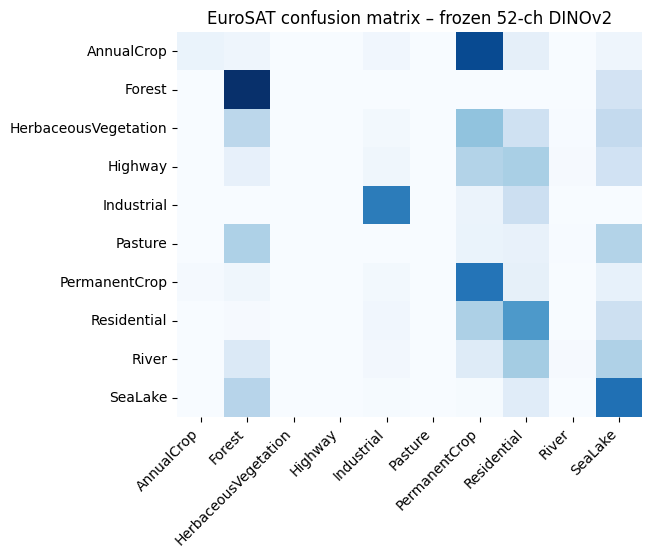

                      precision    recall  f1-score   support

          AnnualCrop       0.70      0.05      0.10      3000
              Forest       0.45      0.84      0.59      3000
HerbaceousVegetation       0.35      0.00      0.00      3000
             Highway       0.00      0.00      0.00      2500
          Industrial       0.77      0.72      0.74      2500
             Pasture       0.00      0.00      0.00      2000
       PermanentCrop       0.25      0.74      0.37      2500
         Residential       0.28      0.50      0.36      3000
               River       0.32      0.01      0.03      2500
             SeaLake       0.32      0.63      0.42      3000

            accuracy                           0.36     27000
           macro avg       0.34      0.35      0.26     27000
        weighted avg       0.36      0.36      0.27     27000



In [ ]:
%pip install seaborn matplotlib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np

# logits from probe over all feats (already on CPU)
pred = probe(feats.to(device)).argmax(1).cpu()
y    = labels  # ground-truth

acc = accuracy_score(y, pred)
print(f"Linear-probe Top-1 accuracy: {acc*100:.2f} %")

cm = confusion_matrix(y, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=eurosat.classes,
            yticklabels=eurosat.classes,
            cbar=False)
plt.xticks(rotation=45, ha="right")
plt.title("EuroSAT confusion matrix – frozen 52-ch DINOv2")
plt.show()

print(classification_report(y, pred, target_names=eurosat.classes))


In [ ]:
import glob, os
print("saved ckpts:", glob.glob("ckpt_epoch*.pt"))


saved ckpts: ['ckpt_epoch000.pt']


In [ ]:
backbone = load_backbone("ckpt_epoch000.pt", device)


In [ ]:
torch.save({"student": student.state_dict()}, "ckpt_epoch000.pt")


In [ ]:
print("num_workers =", loader.num_workers)


num_workers = 4


In [ ]:
import inspect, dinov2
print(inspect.signature(dinov2.loss.DINOLoss))


(out_dim, student_temp=0.1, center_momentum=0.9)


In [ ]:
assert Path("ckpt_epoch000.pt").exists()


In [ ]:
import sys, subprocess, importlib.util, pathlib, textwrap

def run(cmd):
    print("→", " ".join(cmd))
    subprocess.check_call(cmd)

# 1) get dinov2 *without* pulling in xformers
run([sys.executable, "-m", "pip", "install",
     "--no-cache-dir", "--no-compile",
     "git+https://github.com/facebookresearch/dinov2.git@main",
     "--no-deps"])

# 2) add the two light deps it really needs
run([sys.executable, "-m", "pip", "install",
     "--no-cache-dir", "--no-compile",
     "fvcore", "iopath"])

# 3) sanity-check import
spec = importlib.util.find_spec("dinov2")
print("\n✅ dinov2 is now importable from:",
      pathlib.Path(spec.origin).parent)


→ /Users/nishantgupta/ssl4eo-sem-s2c/.venv/bin/python -m pip install --no-cache-dir --no-compile git+https://github.com/facebookresearch/dinov2.git@main --no-deps
  Cloning https://github.com/facebookresearch/dinov2.git (to revision main) to /private/var/folders/kl/d23qsbws5533fvrf3g6yhy4w0000gn/T/pip-req-build-cas4th4i


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/dinov2.git /private/var/folders/kl/d23qsbws5533fvrf3g6yhy4w0000gn/T/pip-req-build-cas4th4i


  Resolved https://github.com/facebookresearch/dinov2.git to commit 4d83ffd4f4b39df112cef7ed7833de7ebf3a202e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
→ /Users/nishantgupta/ssl4eo-sem-s2c/.venv/bin/python -m pip install --no-cache-dir --no-compile fvcore iopath

✅ dinov2 is now importable from: /Users/nishantgupta/ssl4eo-sem-s2c/.venv/lib/python3.9/site-packages/dinov2


In [ ]:
import sys, dinov2
print("Kernel exe :", sys.executable)
print("dinov2 ver :", dinov2.__version__)


Kernel exe : /Users/nishantgupta/ssl4eo-sem-s2c/.venv/bin/python
dinov2 ver : 0.0.1
